In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from segment_anything import SamPredictor, sam_model_registry

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

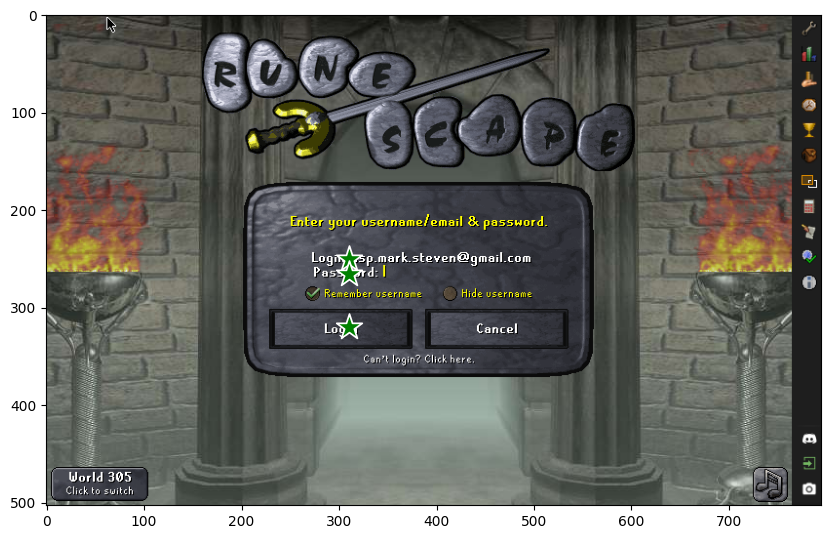

In [3]:
image = cv2.imread('../snapshots/login.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(np.array([[310, 320], [310, 250], [310, 265]]), np.array([1, 1, 1]), plt.gca())
plt.axis('on')
plt.show()

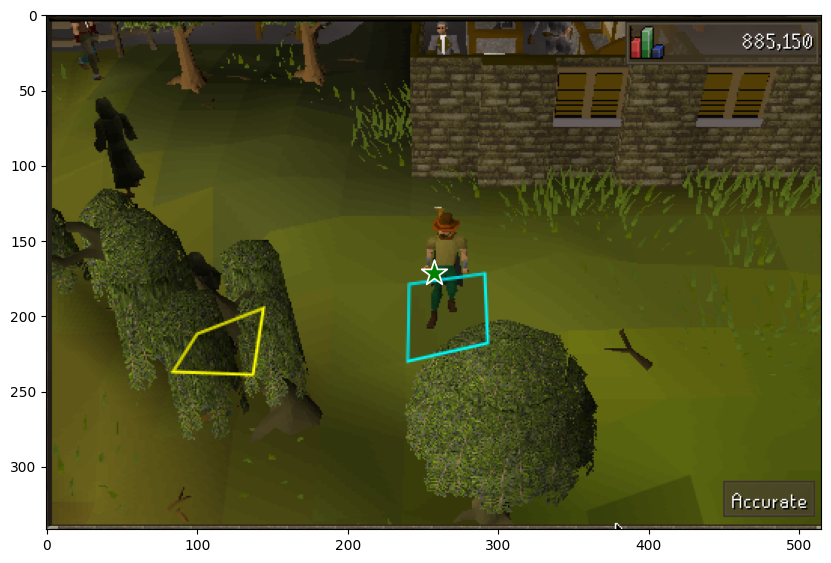

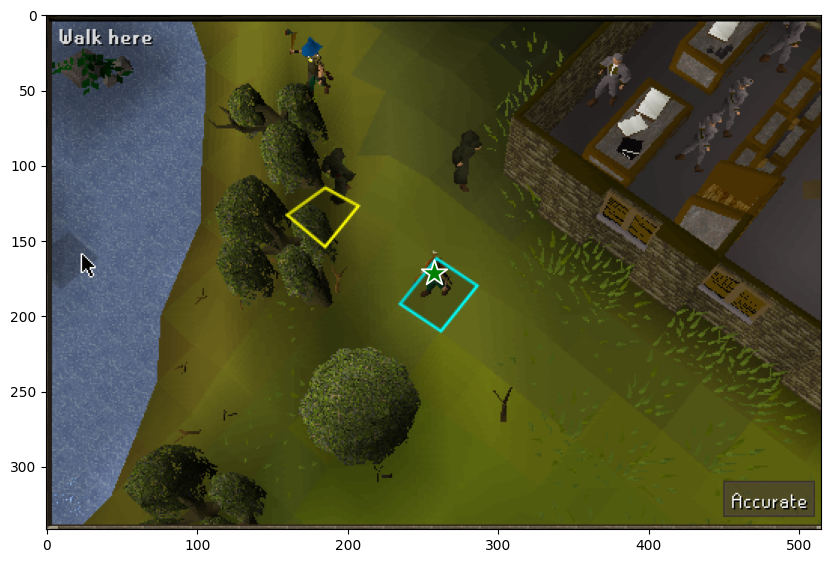

In [4]:
image = cv2.imread('../snapshots/standing_tree.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

INV_RECT = [(546, 204), (736, 467)] # The rectangle of the inventory
MINIMAP_RECT = [(518, 4), (764, 168)] # Includes minimap and prayer
GAME_RECT = [(0, 0), (515, 342)] # The actual game screen
CHAT_RECT = [(8, 345), (500, 460)] # The chat box (just messages received)


for r in [GAME_RECT]:
    r = np.array(r).flatten()
    plt.figure(figsize=(10,10))
    plt.imshow(image[r[1]:r[3], r[0]:r[2]])
    show_points(np.array([[257, 171]]), np.array([1]), plt.gca())
    plt.axis('on')
    plt.show()

high_angle = cv2.imread('../snapshots/high_angle.png')
high_angle = cv2.cvtColor(high_angle, cv2.COLOR_BGR2RGB)

for r in [GAME_RECT]:
    r = np.array(r).flatten()
    plt.figure(figsize=(10,10))
    plt.imshow(high_angle[r[1]:r[3], r[0]:r[2]])
    show_points(np.array([[257, 171]]), np.array([1]), plt.gca())
    plt.axis('on')
    plt.show()


In [6]:
sam_checkpoint = "../models/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "mps"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [11]:
r = np.array(GAME_RECT).flatten()
image = high_angle[r[1]:r[3], r[0]:r[2]]
predictor.set_image(image)
input_point = np.array([[257, 171]])
input_label = np.array([1])

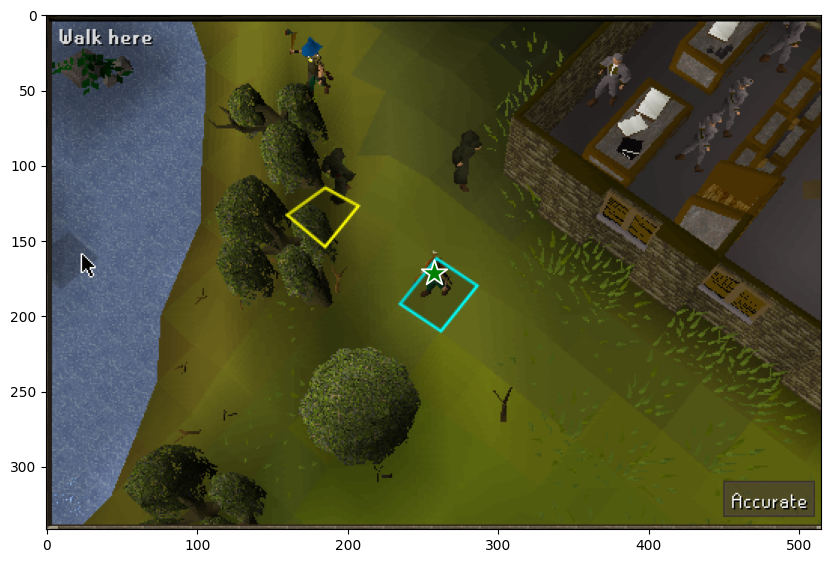

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [13]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

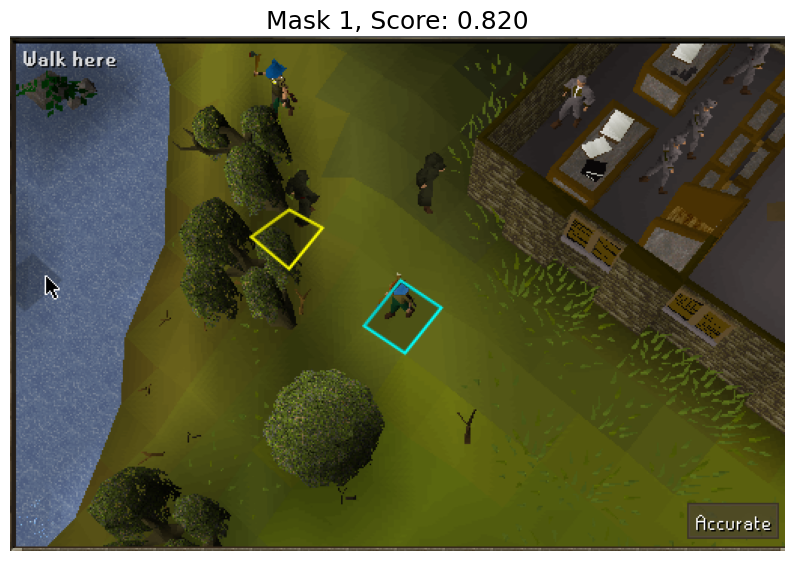

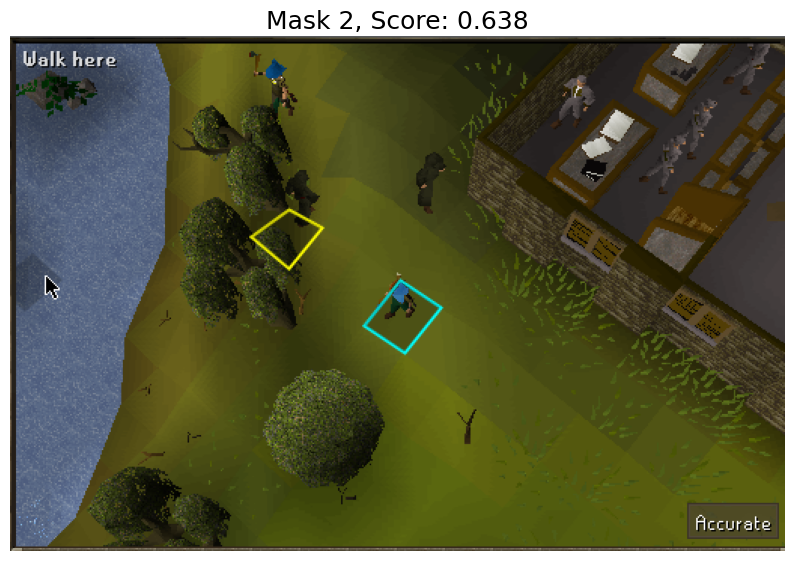

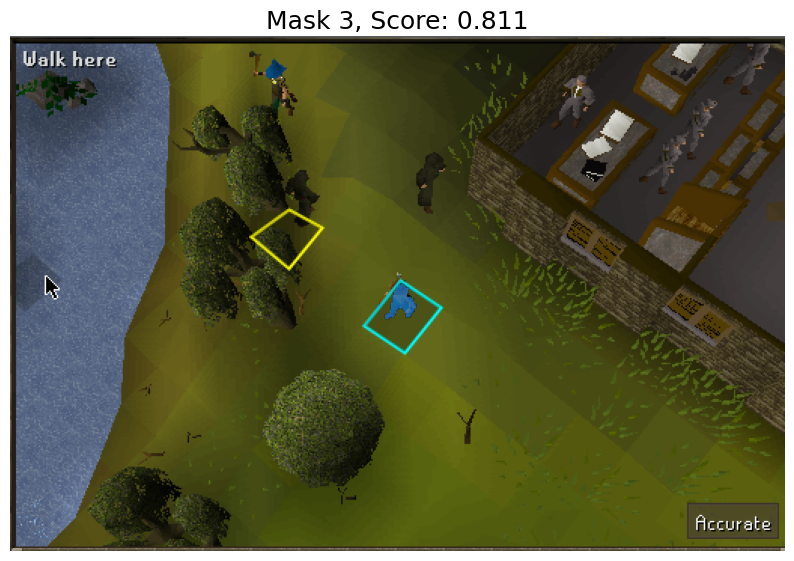

In [15]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    #show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [ ]:
max_i = np.argmax(scores)
best_mask = masks[max_i]

# Show image where mask is applied
np.sum(best_mask)
#np.where(best_mask, image[::-1], np.zeros((503, 795, 3)))
image[~best_mask] = 0

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [ ]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

In [ ]:
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"
device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image)

In [ ]:
masks
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.title(f"All Masks", fontsize=18)
plt.axis('off')
plt.show()  